# **Import Package**

In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ExponentialLR
import torchvision
import torchvision.transforms as transforms
from PIL import Image
from torchsummary import summary
# "ConcatDataset" and "Subset" are possibly useful when doing semi-supervised learning.
from torch.utils.data import ConcatDataset, DataLoader,Subset
from torchvision.datasets import ImageFolder,DatasetFolder
from matplotlib import pyplot as plt 
# This is for the progress bar.
#from tqdm.auto import tqdm
torch.set_printoptions(linewidth=120)
# This is for the progress bar.
from tqdm.auto import tqdm
!pip install torchsummary

# **About the Dataset**

The dataset used here is food-11, a collection of food images in 11 classes.

In [ ]:
# Download the dataset

!gdown --id '1awF7pZ9Dz7X1jn1_QAiKN-_v56veCEKy' --output food-11.zip

# Unzip the dataset.
!unzip -q food-11.zip

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Access denied with the following error:

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1awF7pZ9Dz7X1jn1_QAiKN-_v56veCEKy 

unzip:  cannot find or open food-11.zip, food-11.zip.zip or food-11.zip.ZIP.


# **Dataset, Data Loader, and Transforms**

In [ ]:
# It is important to do data augmentation in training.
# However, not every augmentation is useful.
# Please think about what kind of augmentation is helpful for food recognition.

#set same seed to get same result
torch.manual_seed(17)


#Use a basic transformer
train_tfm_basic = transforms.Compose([
     # Resize the image into a fixed shape (height = width = 128)
     transforms.Resize((128, 128)),
     transforms.ToTensor(),
 ])

# # We don't need augmentations in testing and validation.
test_tfm_basic = transforms.Compose([
     transforms.Resize((128, 128)),
     transforms.ToTensor(),
 ])

#
train_tfm = transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),#随机裁剪到256*256
        #transforms.Resize(256),
        transforms.RandomRotation(degrees=15),#随机旋转
        transforms.RandomHorizontalFlip(),#随机水平翻转
        transforms.CenterCrop(size=224),#中心裁剪到224*224
        transforms.ToTensor(),#转化成张量
        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])

# We don't need augmentations in testing and validation.
# All we need here is to resize the PIL image and transform it into Tensor.
test_tfm = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])

NameError: ignored

In [ ]:
# Batch size for training, validation, and testing.
# A greater batch size usually gives a more stable gradient.
# But the GPU memory is limited, so please adjust it carefully.
batch_size = 64
data_dir = ""
# Construct datasets.
# The argument "loader" tells how torchvision reads the data.
#train_set = DatasetFolder("food-11/training/labeled", loader=lambda x: Image.open(x), extensions="jpg", transform=train_tfm)
#valid_set = DatasetFolder("food-11/validation", loader=lambda x: Image.open(x), extensions="jpg", transform=test_tfm)
#unlabeled_set = DatasetFolder("food-11/training/unlabeled", loader=lambda x: Image.open(x), extensions="jpg", transform=train_tfm)
#test_set = DatasetFolder("food-11/testing", loader=lambda x: Image.open(x), extensions="jpg", transform=test_tfm)

#dataset for basic model
train_set_basic = DatasetFolder("food-11/training/labeled", loader=lambda x: Image.open(x), extensions="jpg", transform=train_tfm_basic)
valid_set_basic = DatasetFolder("food-11/validation", loader=lambda x: Image.open(x), extensions="jpg", transform=test_tfm_basic)
unlabeled_set_basic = DatasetFolder("food-11/training/unlabeled", loader=lambda x: Image.open(x), extensions="jpg", transform=train_tfm_basic)
test_set_basic = DatasetFolder("food-11/testing", loader=lambda x: Image.open(x), extensions="jpg", transform=test_tfm_basic)
train_loader_basic = DataLoader(train_set_basic, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
valid_loader_basic = DataLoader(valid_set_basic, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
test_loader_basic = DataLoader(test_set_basic, batch_size=batch_size, shuffle=False)

#dataset for augmentation
train_set = ImageFolder(data_dir+"food-11/training/labeled",transform=train_tfm)
valid_set = ImageFolder(data_dir+"food-11/validation", transform=test_tfm)
unlabeled_set = ImageFolder(data_dir+"food-11/training/unlabeled", transform=train_tfm)
test_set = ImageFolder(data_dir+"food-11/testing", transform=test_tfm)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True,drop_last=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True,drop_last=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
def get_pseudo_labels(dataset, model, filter_index, batch_size,threshold=0.95):
    # This functions generates pseudo-labels of a dataset using given model.
    # It returns an instance of DatasetFolder containing images whose prediction confidences exceed a given threshold.
    # You are NOT allowed to use any models trained on external data for pseudo-labeling.
    device = "cuda" if torch.cuda.is_available() else "cpu"
    #print(device)
    # Make sure the model is in eval mode.
    model.eval()
    # Define softmax function.
    softmax = nn.Softmax(dim=-1)

    filter_dataset = []
    filter_index = []
    filter_labels = []
    filter_cnt = 0
    batch_cnt = 0 
    cnt = 0
    # Iterate over the dataset by batches.
    unlabeled_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False,num_workers=4,drop_last=True)
    for batch in unlabeled_loader:
        imgs,_ = batch
        # Forward the data
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            logits = model(imgs.to(device))

        # Obtain the probability distributions by applying softmax on logits.
        probs = softmax(logits) 
        #probs_max = probs.argmax(dim=-1)
        #print(probs)
        #print(probs_max)
        #loop_cnt = probs_max.shape[0]
        #print(loop_cnt)
        
        # ---------- TODO ----------
        # Filter the data and construct a new dataset.
        for p in probs:
            #print(max(probs[i]))
            if torch.max(p) > threshold:
                if cnt not in filter_index:
                    filter_index.append(cnt)
                    filter_labels.append(torch.argmax(p).cpu())
                    #filter_dataset.append([imgs[i],probs_max[i]])
                    filter_cnt = filter_cnt + 1 
                    #print("filter labels = " + str(cnt) + ':' + str(torch.argmax(p)))
            cnt = cnt +1       
    #print("filter count = " + str(filter_cnt))
    #print("filter index = " + str(filter_index))
    #print("filter labels = " + str(filter_labels))
    # # Turn off the eval mode.
    #model.train()
    sub_dataset = Subset(dataset, filter_index)
    sub_dataset.targets = filter_labels
    #print(filter_index)
    #print(sub_dataset.targets)
    return sub_dataset,filter_index


# **Basic Model**

## The model use Basic Structure + No_Semi + No_augmentation

In [ ]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()

        # input image size: [3, 128, 128]
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(128, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(4, 4, 0),
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(256 * 8 * 8, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 11)
        )

    def forward(self, x):
        # input (x): [batch_size, 3, 128, 128]
        # output: [batch_size, 11]

        # Extract features by convolutional layers.
        x = self.cnn_layers(x)

        # The extracted feature map must be flatten before going to fully-connected layers.
        x = x.flatten(1)

        # The features are transformed by fully-connected layers to obtain the final logits.
        x = self.fc_layers(x)
        return x

In [ ]:
# "cuda" only when GPUs are available.
device = "cuda" if torch.cuda.is_available() else "cpu"

#record the results
record = []

lr = 3*1e-4
gamma = 0.9
# Initialize a model, and put it on the device specified.
model = Classifier().to(device)
model.device = device

# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
#scheduler = ExponentialLR(optimizer=optimizer, gamma=gamma)
#torch.cuda.empty_cache()

# The number of training epochs.
n_epochs = 30

for epoch in range(n_epochs):
    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []

    # Iterate the training set by batches.
    for batch in tqdm(train_loader_basic):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch

        # Forward the data. (Make sure data and model are on the same device.)
        logits = model(imgs.to(device))

        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it is done automatically.
        loss = criterion(logits, labels.to(device))

        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()

        # Compute the gradients for parameters.
        loss.backward()

        # Clip the gradient norms for stable training.
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)

        # Update the parameters with computed gradients.
        optimizer.step()

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc)

    # The average loss and accuracy of the training set is the average of the recorded values.
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)

    # Print the information.
    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")

    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []

    # Iterate the validation set by batches.
    for batch in tqdm(valid_loader_basic):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
          logits = model(imgs.to(device))

        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels.to(device))

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc)

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)

    # Print the information.
    print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")

    record.append([train_loss, valid_loss, train_acc.cpu(), valid_acc.cpu(),optimizer.param_groups[0]['lr']])
    #print("learning rate: "+ str(optimizer.param_groups[0]['lr']))
    #scheduler.step()
    #torch.cuda.empty_cache()

  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 001/030 ] loss = 2.15047, acc = 0.22959


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 001/030 ] loss = 2.10462, acc = 0.27585


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 002/030 ] loss = 1.85563, acc = 0.34694


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 002/030 ] loss = 1.85254, acc = 0.35398


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 003/030 ] loss = 1.65799, acc = 0.41869


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 003/030 ] loss = 1.93490, acc = 0.32670


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 004/030 ] loss = 1.47866, acc = 0.48661


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 004/030 ] loss = 1.89117, acc = 0.37614


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 005/030 ] loss = 1.33801, acc = 0.54209


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 005/030 ] loss = 1.73316, acc = 0.43324


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 006/030 ] loss = 1.25614, acc = 0.58163


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 006/030 ] loss = 1.66529, acc = 0.42955


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 007/030 ] loss = 1.07705, acc = 0.64222


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 007/030 ] loss = 1.62808, acc = 0.44943


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 008/030 ] loss = 0.93525, acc = 0.68654


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 008/030 ] loss = 1.64083, acc = 0.46051


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 009/030 ] loss = 0.81681, acc = 0.72449


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 009/030 ] loss = 1.76237, acc = 0.46676


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 010/030 ] loss = 0.71812, acc = 0.76244


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 010/030 ] loss = 1.74209, acc = 0.47244


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 011/030 ] loss = 0.58646, acc = 0.80708


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 011/030 ] loss = 1.71873, acc = 0.49574


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 012/030 ] loss = 0.44531, acc = 0.85651


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 012/030 ] loss = 1.89378, acc = 0.47244


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 013/030 ] loss = 0.34760, acc = 0.89668


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 013/030 ] loss = 1.88230, acc = 0.47131


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 014/030 ] loss = 0.29296, acc = 0.91805


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 014/030 ] loss = 1.96341, acc = 0.47273


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 015/030 ] loss = 0.25024, acc = 0.93144


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 015/030 ] loss = 2.10019, acc = 0.47926


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 016/030 ] loss = 0.18158, acc = 0.95089


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 016/030 ] loss = 2.25238, acc = 0.44489


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 017/030 ] loss = 0.10749, acc = 0.98119


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 017/030 ] loss = 2.27265, acc = 0.46307


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 018/030 ] loss = 0.06176, acc = 0.99362


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 018/030 ] loss = 2.19442, acc = 0.48040


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 019/030 ] loss = 0.07580, acc = 0.98597


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 019/030 ] loss = 2.40946, acc = 0.45937


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 020/030 ] loss = 0.07322, acc = 0.98756


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 020/030 ] loss = 2.28508, acc = 0.50256


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 021/030 ] loss = 0.06084, acc = 0.98948


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 021/030 ] loss = 2.56318, acc = 0.47472


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 022/030 ] loss = 0.02913, acc = 0.99809


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 022/030 ] loss = 2.52058, acc = 0.49602


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 023/030 ] loss = 0.02061, acc = 0.99872


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 023/030 ] loss = 2.46799, acc = 0.50739


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 024/030 ] loss = 0.06435, acc = 0.98469


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 024/030 ] loss = 2.42940, acc = 0.47756


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 025/030 ] loss = 0.06608, acc = 0.98278


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 025/030 ] loss = 2.70736, acc = 0.46108


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 026/030 ] loss = 0.08046, acc = 0.97927


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 026/030 ] loss = 2.85620, acc = 0.47358


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 027/030 ] loss = 0.09419, acc = 0.96684


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 027/030 ] loss = 2.66363, acc = 0.45937


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 028/030 ] loss = 0.08060, acc = 0.97768


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 028/030 ] loss = 3.15861, acc = 0.45227


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 029/030 ] loss = 0.03334, acc = 0.99490


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 029/030 ] loss = 2.84460, acc = 0.46392


  0%|          | 0/49 [00:00<?, ?it/s]

[ Train | 030/030 ] loss = 0.03561, acc = 0.99235


  0%|          | 0/11 [00:00<?, ?it/s]

[ Valid | 030/030 ] loss = 3.23043, acc = 0.45767


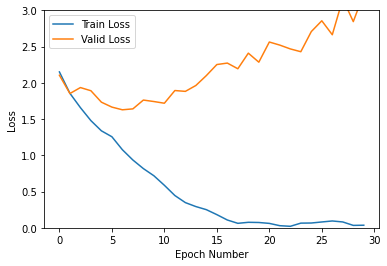

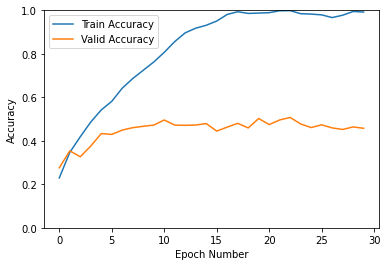

In [ ]:
torch.save(model,"./food-11.basic_model_no_semi")

record = np.array(record)
plt.plot(record[:, 0:2])
plt.legend(['Train Loss', 'Valid Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0, 3)
#plt.savefig('loss.png')
plt.show()

plt.plot(record[:, 2:4])
plt.legend(['Train Accuracy', 'Valid Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
#plt.savefig('accuracy.png')
plt.show()

# plt.plot(record[:, 4])
# plt.legend(['Learning Rate'])
# plt.xlabel('Epoch Number')
# plt.ylabel('Learning Rate')
# plt.ylim(0, lr)
# plt.show()

In [ ]:
model.eval()
predictions = []
for batch in test_loader_basic:
    imgs, labels = batch
    with torch.no_grad():
        logits = model(imgs.to(device))
    predictions.extend(logits.argmax(dim=-1).cpu().numpy().tolist())

with open("predict_basic_no_semi.csv", "w") as f:

    f.write("Id,Category\n")
    for i, pred in  enumerate(predictions):
         f.write(f"{i},{pred}")

## The model use Basic Structure + Semi + No_augmentation

In [ ]:
# "cuda" only when GPUs are available.
device = "cuda" if torch.cuda.is_available() else "cpu"
#record the results
record = []
lr = 0.0003

# Initialize a model, and put it on the device specified.
model = Classifier().to(device)
model.device = device

# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)

# The number of training epochs.
n_epochs = 30
filter_index = []
for epoch in range(n_epochs):
    #--------pseudo labeling------
    pseudo_set_basic,filter_index = get_pseudo_labels(unlabeled_set_basic, model,filter_index, batch_size, threshold=0.9)
    # Construct a new dataset and a data loader for training.
    # This is used in semi-supervised learning only.
    concat_dataset_basic = ConcatDataset([train_set_basic, pseudo_set_basic])
    print("train_set size: "+ str(len(train_set_basic)))
    print("pseudo_set size: "+ str(len(pseudo_set_basic)))
    print("concat_set size: "+ str(len(concat_dataset_basic)))
    train_loader_basic = DataLoader(concat_dataset_basic, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)

    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []

    # Iterate the training set by batches.
    for batch in tqdm(train_loader_basic):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch

        # Forward the data. (Make sure data and model are on the same device.)
        logits = model(imgs.to(device))

        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it is done automatically.
        loss = criterion(logits, labels.to(device))

        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()

        # Compute the gradients for parameters.
        loss.backward()

        # Clip the gradient norms for stable training.
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)

        # Update the parameters with computed gradients.
        optimizer.step()

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc)

    # The average loss and accuracy of the training set is the average of the recorded values.
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)

    # Print the information.
    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")

    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []

    # Iterate the validation set by batches.
    for batch in tqdm(valid_loader_basic):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
          logits = model(imgs.to(device))

        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels.to(device))

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc)

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)

    # Print the information.
    print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")

    record.append([train_loss, valid_loss, train_acc.cpu(), valid_acc.cpu(),optimizer.param_groups[0]['lr']])

NameError: ignored

In [ ]:
torch.save(model,"./food-11.basic_model_semi")

record = np.array(record)
plt.plot(record[:, 0:2])
plt.legend(['Train Loss', 'Valid Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0, 3)
#plt.savefig('loss.png')
plt.show()

plt.plot(record[:, 2:4])
plt.legend(['Train Accuracy', 'Valid Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
#plt.savefig('accuracy.png')
plt.show()

# plt.plot(record[:, 4])
# plt.legend(['Learning Rate'])
# plt.xlabel('Epoch Number')
# plt.ylabel('Learning Rate')
# plt.ylim(0, lr)
# plt.show()

In [ ]:
model.eval()
predictions = []
for batch in test_loader_basic:
    imgs, labels = batch
    with torch.no_grad():
        logits = model(imgs.to(device))
    predictions.extend(logits.argmax(dim=-1).cpu().numpy().tolist())

with open("predict_basic_semi.csv", "w") as f:

    f.write("Id,Category\n")
    for i, pred in  enumerate(predictions):
         f.write(f"{i},{pred}")

# **Advanced Model**

## The model use Advanced Structure + No_Semi + Augmentation 

In [ ]:
import time
# "cuda" only when GPUs are available.
device = "cuda" if torch.cuda.is_available() else "cpu"
# The number of training epochs.
n_epochs = 30
# Whether to do semi-supervised learning.
train_acc = 0
pseudo_threshold = 0.6
lr = 1*1e-4
gamma = 0.9
cnt_of_estop = 0
early_stop_threshold = 5
filter_index = []
record = []

semi_supervised = False
use_saved_model = False
use_pretrained_model = True
lr_decay_enable = True


resnet = torchvision.models.resnet18(pretrained=False)
resnet.fc = nn.Sequential(
                nn.BatchNorm1d(resnet.fc.in_features),#important layer
                nn.Linear(resnet.fc.in_features, resnet.fc.in_features),
                nn.BatchNorm1d(resnet.fc.in_features),#important layer                
                nn.ReLU(),
                nn.Dropout(0.5),
                nn.Linear(resnet.fc.in_features, 1024),
                nn.BatchNorm1d(1024),#important layer                
                nn.ReLU(),
                nn.Dropout(0.5),
                nn.Linear(1024, 11),
            )    

model = resnet.to(device)
model.device = device
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
scheduler = ExponentialLR(optimizer=optimizer, gamma=gamma)
torch.cuda.empty_cache()

In [ ]:
record = []
#n_epochs = 10
for epoch in range(n_epochs): 
    if semi_supervised:
        pseudo_set,filter_index = get_pseudo_labels(unlabeled_set, model,filter_index, batch_size,threshold=pseudo_threshold)
        concat_dataset = ConcatDataset([train_set, pseudo_set])
        print("train_set size: "+ str(len(train_set)))
        print("pseudo_set size: "+ str(len(pseudo_set)))
        print("concat_set size: "+ str(len(concat_dataset)))
        train_loader = DataLoader(concat_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True,drop_last=True)        
        

    model.train()
    train_loss = []
    train_accs = []
    i = 0 
    start = time.time()
    for batch in train_loader:
        imgs, labels = batch
        logits = model(imgs.to(device))
        loss = criterion(logits, labels.to(device))
        optimizer.zero_grad()
        loss.backward()
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)
        optimizer.step()
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()
        train_loss.append(loss.item())
        train_accs.append(acc)
        i = i + 1

    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)
    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}, time = {time.time()-start:.2f}")

    model.eval()
    valid_loss = []
    valid_accs = []
    start = time.time()
    # Iterate the validation set by batches.
    for batch in valid_loader:

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            logits = model(imgs.to(device))

        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels.to(device))

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc)

    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)


    print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}, time = {time.time()-start:.2f}")

    record.append([train_loss, valid_loss, train_acc.cpu(), valid_acc.cpu(),optimizer.param_groups[0]['lr']])    
    
    print("learning rate: "+ str(optimizer.param_groups[0]['lr']))
    scheduler.step()
    torch.cuda.empty_cache()

    if train_acc > (valid_acc+0.1):                    #allow +10% overfitting
        cnt_of_estop = cnt_of_estop + 1
    else:
        cnt_of_estop = 0

    if cnt_of_estop > early_stop_threshold:
        print("early stop break: " + str(cnt_of_estop))
        break
    else:
        print("early stop count: " + str(cnt_of_estop))      

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[ Train | 001/030 ] loss = 2.30582, acc = 0.17806, time = 24.95
[ Valid | 001/030 ] loss = 2.05853, acc = 0.28594, time = 5.90
learning rate: 0.0001
early stop count: 0
[ Train | 002/030 ] loss = 2.01185, acc = 0.29785, time = 24.35
[ Valid | 002/030 ] loss = 1.90588, acc = 0.34219, time = 6.11
learning rate: 9e-05
early stop count: 0
[ Train | 003/030 ] loss = 1.87732, acc = 0.34505, time = 24.57
[ Valid | 003/030 ] loss = 1.82237, acc = 0.38125, time = 5.99
learning rate: 8.1e-05
early stop count: 0
[ Train | 004/030 ] loss = 1.78336, acc = 0.37695, time = 25.33
[ Valid | 004/030 ] loss = 1.78523, acc = 0.38906, time = 6.15
learning rate: 7.290000000000001e-05
early stop count: 0
[ Train | 005/030 ] loss = 1.71689, acc = 0.40430, time = 25.48
[ Valid | 005/030 ] loss = 1.70337, acc = 0.41406, time = 6.27
learning rate: 6.561000000000002e-05
early stop count: 0
[ Train | 006/030 ] loss = 1.66943, acc = 0.43197, time = 26.02
[ Valid | 006/030 ] loss = 1.61956, acc = 0.44531, time = 6.2

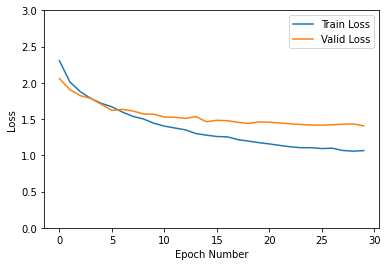

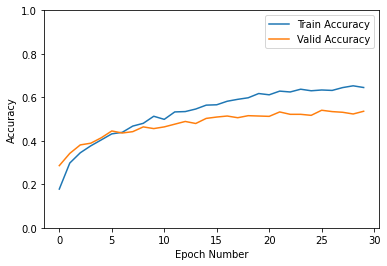

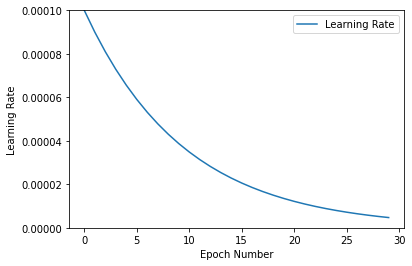

In [ ]:
torch.save(model,"./food-11.model_no_semi")

record = np.array(record)
plt.plot(record[:, 0:2])
plt.legend(['Train Loss', 'Valid Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0, 3)
#plt.savefig('loss.png')
plt.show()

plt.plot(record[:, 2:4])
plt.legend(['Train Accuracy', 'Valid Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
#plt.savefig('accuracy.png')
plt.show()

plt.plot(record[:, 4])
plt.legend(['Learning Rate'])
plt.xlabel('Epoch Number')
plt.ylabel('Learning Rate')
plt.ylim(0, lr)
plt.show()

In [ ]:
model.eval()
predictions = []
for batch in test_loader:
    imgs, labels = batch
    with torch.no_grad():
        logits = model(imgs.to(device))
    predictions.extend(logits.argmax(dim=-1).cpu().numpy().tolist())

with open("predictno_semi.csv", "w") as f:

    # The first row must be "Id, Category"
    f.write("Id,Category\n")

    # For the rest of the rows, each image id corresponds to a predicted class.
    for i, pred in  enumerate(predictions):
         f.write(f"{i},{pred} \n")

## The model use Advanced Structure + Threshold 0.6 + Augmentation 

In [ ]:
pseudo_threshold = 0.6
record_6 = []
semi_supervised = True

resnet = torchvision.models.resnet18(pretrained=False)
resnet.fc = nn.Sequential(
                nn.BatchNorm1d(resnet.fc.in_features),#important layer
                nn.Linear(resnet.fc.in_features, resnet.fc.in_features),
                nn.BatchNorm1d(resnet.fc.in_features),#important layer                
                nn.ReLU(),
                nn.Dropout(0.5),
                nn.Linear(resnet.fc.in_features, 1024),
                nn.BatchNorm1d(1024),#important layer                
                nn.ReLU(),
                nn.Dropout(0.5),
                nn.Linear(1024, 11),
            )    

model_6 = resnet.to(device)
model_6.device = device
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_6.parameters(), lr=lr, weight_decay=1e-5)
scheduler = ExponentialLR(optimizer=optimizer, gamma=gamma)
torch.cuda.empty_cache()

In [ ]:
for epoch in range(n_epochs): 
    if semi_supervised:
        pseudo_set,filter_index = get_pseudo_labels(unlabeled_set, model_6,filter_index, batch_size,threshold=pseudo_threshold)
        concat_dataset = ConcatDataset([train_set, pseudo_set])
        print("train_set size: "+ str(len(train_set)))
        print("pseudo_set size: "+ str(len(pseudo_set)))
        print("concat_set size: "+ str(len(concat_dataset)))
        train_loader = DataLoader(concat_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True,drop_last=True)        
        
    model_6.train()
    train_loss = []
    train_accs = []
    i = 0 
    start = time.time()
    for batch in train_loader:
        imgs, labels = batch
        logits = model_6(imgs.to(device))
        loss = criterion(logits, labels.to(device))
        optimizer.zero_grad()
        loss.backward()
        grad_norm = nn.utils.clip_grad_norm_(model_6.parameters(), max_norm=10)
        optimizer.step()
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()
        train_loss.append(loss.item())
        train_accs.append(acc)
        i = i + 1
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)

    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}, time = {time.time()-start:.2f}")

    model_6.eval()
    valid_loss = []
    valid_accs = []
    start = time.time()
    for batch in valid_loader:
        imgs, labels = batch
        with torch.no_grad():
            logits = model_6(imgs.to(device))

        loss = criterion(logits, labels.to(device))
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()
        valid_loss.append(loss.item())
        valid_accs.append(acc)
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)

    print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}, time = {time.time()-start:.2f}")
    record_6.append([train_loss, valid_loss, train_acc.cpu(), valid_acc.cpu(),optimizer.param_groups[0]['lr']])    
    
    print("learning rate: "+ str(optimizer.param_groups[0]['lr']))
    scheduler.step()
    torch.cuda.empty_cache()
    
    if train_acc > (valid_acc+0.1):                    #allow +10% overfitting
        cnt_of_estop = cnt_of_estop + 1
    else:
        cnt_of_estop = 0

    if cnt_of_estop > early_stop_threshold:
        print("early stop break: " + str(cnt_of_estop))
        break
    else:
        print("early stop count: " + str(cnt_of_estop))      

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_set size: 3080
pseudo_set size: 0
concat_set size: 3080
[ Train | 001/030 ] loss = 2.25810, acc = 0.19531, time = 29.43
[ Valid | 001/030 ] loss = 2.08068, acc = 0.25000, time = 6.35
learning rate: 0.0001
early stop count: 0
train_set size: 3080
pseudo_set size: 345
concat_set size: 3425
[ Train | 002/030 ] loss = 2.04431, acc = 0.28007, time = 30.19
[ Valid | 002/030 ] loss = 1.93303, acc = 0.33594, time = 6.21
learning rate: 9e-05
early stop count: 0
train_set size: 3080
pseudo_set size: 551
concat_set size: 3631
[ Train | 003/030 ] loss = 1.88492, acc = 0.30887, time = 34.54
[ Valid | 003/030 ] loss = 1.82677, acc = 0.36406, time = 6.15
learning rate: 8.1e-05
early stop count: 0
train_set size: 3080
pseudo_set size: 237
concat_set size: 3317
[ Train | 004/030 ] loss = 1.89440, acc = 0.31464, time = 27.62
[ Valid | 004/030 ] loss = 1.83893, acc = 0.35469, time = 5.78
learning rate: 7.290000000000001e-05
early stop count: 0
train_set size: 3080
pseudo_set size: 327
concat_set si

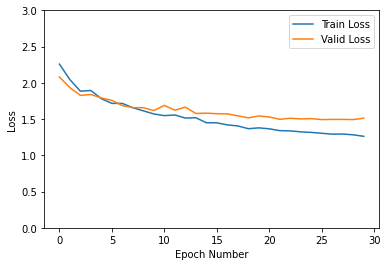

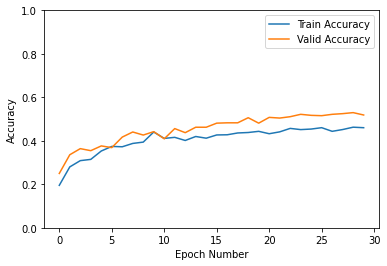

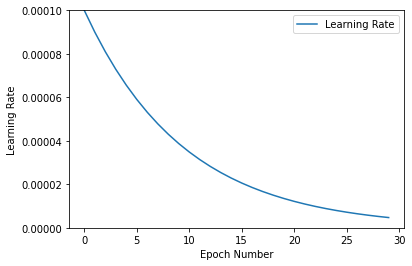

In [ ]:
torch.save(model,"./food-11.model_semi_6")

record_6 = np.array(record_6)
plt.plot(record_6[:, 0:2])
plt.legend(['Train Loss', 'Valid Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0, 3)
#plt.savefig('loss.png')
plt.show()

plt.plot(record_6[:, 2:4])
plt.legend(['Train Accuracy', 'Valid Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
#plt.savefig('accuracy.png')
plt.show()

plt.plot(record_6[:, 4])
plt.legend(['Learning Rate'])
plt.xlabel('Epoch Number')
plt.ylabel('Learning Rate')
plt.ylim(0, lr)
plt.show()

In [ ]:
model_6.eval()
predictions = []
for batch in test_loader:
    imgs, labels = batch
    with torch.no_grad():
        logits = model_6(imgs.to(device))
    predictions.extend(logits.argmax(dim=-1).cpu().numpy().tolist())

with open("predict6.csv", "w") as f:

    # The first row must be "Id, Category"
    f.write("Id,Category\n")

    # For the rest of the rows, each image id corresponds to a predicted class.
    for i, pred in  enumerate(predictions):
         f.write(f"{i},{pred} \n")

## The model use Advanced Structure + Threshold 0.75 + Augmentation 

In [ ]:
pseudo_threshold = 0.75
record_75 = []
semi_supervised = True

resnet = torchvision.models.resnet18(pretrained=False)
resnet.fc = nn.Sequential(
                nn.BatchNorm1d(resnet.fc.in_features),#important layer
                nn.Linear(resnet.fc.in_features, resnet.fc.in_features),
                nn.BatchNorm1d(resnet.fc.in_features),#important layer                
                nn.ReLU(),
                nn.Dropout(0.5),
                nn.Linear(resnet.fc.in_features, 1024),
                nn.BatchNorm1d(1024),#important layer                
                nn.ReLU(),
                nn.Dropout(0.5),
                nn.Linear(1024, 11),
            )    

model_75 = resnet.to(device)
model_75.device = device
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_75.parameters(), lr=lr, weight_decay=1e-5)
scheduler = ExponentialLR(optimizer=optimizer, gamma=gamma)
torch.cuda.empty_cache()

In [ ]:
for epoch in range(n_epochs): 
    if semi_supervised:
        pseudo_set,filter_index = get_pseudo_labels(unlabeled_set, model_75,filter_index, batch_size,threshold=pseudo_threshold)
        concat_dataset = ConcatDataset([train_set, pseudo_set])
        print("train_set size: "+ str(len(train_set)))
        print("pseudo_set size: "+ str(len(pseudo_set)))
        print("concat_set size: "+ str(len(concat_dataset)))
        train_loader = DataLoader(concat_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True,drop_last=True)        
        
    model_75.train()
    train_loss = []
    train_accs = []
    i = 0 
    start = time.time()
    for batch in train_loader:
        imgs, labels = batch
        logits = model_75(imgs.to(device))
        loss = criterion(logits, labels.to(device))
        optimizer.zero_grad()
        loss.backward()
        grad_norm = nn.utils.clip_grad_norm_(model_75.parameters(), max_norm=10)
        optimizer.step()
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()
        train_loss.append(loss.item())
        train_accs.append(acc)
        i = i + 1
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)

    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}, time = {time.time()-start:.2f}")

    model_75.eval()
    valid_loss = []
    valid_accs = []
    start = time.time()
    for batch in valid_loader:
        imgs, labels = batch
        with torch.no_grad():
            logits = model_75(imgs.to(device))

        loss = criterion(logits, labels.to(device))
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()
        valid_loss.append(loss.item())
        valid_accs.append(acc)
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)

    print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}, time = {time.time()-start:.2f}")
    record_75.append([train_loss, valid_loss, train_acc.cpu(), valid_acc.cpu(),optimizer.param_groups[0]['lr']])    
    
    print("learning rate: "+ str(optimizer.param_groups[0]['lr']))
    scheduler.step()
    torch.cuda.empty_cache()
    
    if train_acc > (valid_acc+0.1):                    #allow +10% overfitting
        cnt_of_estop = cnt_of_estop + 1
    else:
        cnt_of_estop = 0

    if cnt_of_estop > early_stop_threshold:
        print("early stop break: " + str(cnt_of_estop))
        break
    else:
        print("early stop count: " + str(cnt_of_estop))      

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_set size: 3080
pseudo_set size: 0
concat_set size: 3080
[ Train | 001/030 ] loss = 2.26660, acc = 0.19466, time = 29.42
[ Valid | 001/030 ] loss = 2.07359, acc = 0.25938, time = 6.99
learning rate: 0.0001
early stop count: 0
train_set size: 3080
pseudo_set size: 60
concat_set size: 3140
[ Train | 002/030 ] loss = 2.04650, acc = 0.28284, time = 32.48
[ Valid | 002/030 ] loss = 1.96547, acc = 0.30469, time = 7.10
learning rate: 9e-05
early stop count: 0
train_set size: 3080
pseudo_set size: 131
concat_set size: 3211
[ Train | 003/030 ] loss = 1.90408, acc = 0.32219, time = 31.92
[ Valid | 003/030 ] loss = 1.81920, acc = 0.36250, time = 6.84
learning rate: 8.1e-05
early stop count: 0
train_set size: 3080
pseudo_set size: 146
concat_set size: 3226
[ Train | 004/030 ] loss = 1.83796, acc = 0.34094, time = 32.84
[ Valid | 004/030 ] loss = 1.85393, acc = 0.35781, time = 7.03
learning rate: 7.290000000000001e-05
early stop count: 0
train_set size: 3080
pseudo_set size: 199
concat_set siz

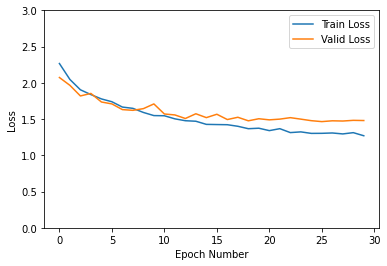

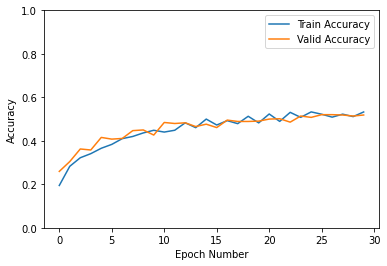

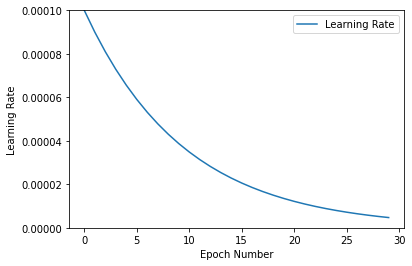

In [ ]:
torch.save(model,"./food-11.model_semi_75")

record_75 = np.array(record_75)
plt.plot(record_75[:, 0:2])
plt.legend(['Train Loss', 'Valid Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0, 3)
#plt.savefig('loss.png')
plt.show()

plt.plot(record_75[:, 2:4])
plt.legend(['Train Accuracy', 'Valid Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
#plt.savefig('accuracy.png')
plt.show()

plt.plot(record_75[:, 4])
plt.legend(['Learning Rate'])
plt.xlabel('Epoch Number')
plt.ylabel('Learning Rate')
plt.ylim(0, lr)
plt.show()

In [ ]:
model_75.eval()
predictions = []
for batch in test_loader:
    imgs, labels = batch
    with torch.no_grad():
        logits = model_75(imgs.to(device))
    predictions.extend(logits.argmax(dim=-1).cpu().numpy().tolist())

with open("predict75.csv", "w") as f:

    # The first row must be "Id, Category"
    f.write("Id,Category\n")

    # For the rest of the rows, each image id corresponds to a predicted class.
    for i, pred in  enumerate(predictions):
         f.write(f"{i},{pred} \n")

## The model use Advanced Structure + Threshold 0.9 + Augmentation 







In [ ]:
pseudo_threshold = 0.9
record_9 = []
semi_supervised = True

resnet = torchvision.models.resnet18(pretrained=False)
resnet.fc = nn.Sequential(
                nn.BatchNorm1d(resnet.fc.in_features),#important layer
                nn.Linear(resnet.fc.in_features, resnet.fc.in_features),
                nn.BatchNorm1d(resnet.fc.in_features),#important layer                
                nn.ReLU(),
                nn.Dropout(0.5),
                nn.Linear(resnet.fc.in_features, 1024),
                nn.BatchNorm1d(1024),#important layer                
                nn.ReLU(),
                nn.Dropout(0.5),
                nn.Linear(1024, 11),
            )    

model_9 = resnet.to(device)
model_9.device = device
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_9.parameters(), lr=lr, weight_decay=1e-5)
scheduler = ExponentialLR(optimizer=optimizer, gamma=gamma)
torch.cuda.empty_cache()

In [ ]:
for epoch in range(n_epochs): 
    if semi_supervised:
        pseudo_set,filter_index = get_pseudo_labels(unlabeled_set, model_9,filter_index, batch_size,threshold=pseudo_threshold)
        concat_dataset = ConcatDataset([train_set, pseudo_set])
        print("train_set size: "+ str(len(train_set)))
        print("pseudo_set size: "+ str(len(pseudo_set)))
        print("concat_set size: "+ str(len(concat_dataset)))
        train_loader = DataLoader(concat_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True,drop_last=True)        
        
    model_9.train()
    train_loss = []
    train_accs = []
    i = 0 
    start = time.time()
    for batch in train_loader:
        imgs, labels = batch
        logits = model_9(imgs.to(device))
        loss = criterion(logits, labels.to(device))
        optimizer.zero_grad()
        loss.backward()
        grad_norm = nn.utils.clip_grad_norm_(model_9.parameters(), max_norm=10)
        optimizer.step()
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()
        train_loss.append(loss.item())
        train_accs.append(acc)
        i = i + 1
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)

    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}, time = {time.time()-start:.2f}")

    model_9.eval()
    valid_loss = []
    valid_accs = []
    start = time.time()
    for batch in valid_loader:
        imgs, labels = batch
        with torch.no_grad():
            logits = model_9(imgs.to(device))

        loss = criterion(logits, labels.to(device))
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()
        valid_loss.append(loss.item())
        valid_accs.append(acc)
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)

    print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}, time = {time.time()-start:.2f}")
    
    record_9.append([train_loss, valid_loss, train_acc.cpu(), valid_acc.cpu(),optimizer.param_groups[0]['lr']])    
    
    print("learning rate: "+ str(optimizer.param_groups[0]['lr']))
    scheduler.step()
    torch.cuda.empty_cache()
    
    if train_acc > (valid_acc+0.1):                    #allow +10% overfitting
        cnt_of_estop = cnt_of_estop + 1
    else:
        cnt_of_estop = 0

    if cnt_of_estop > early_stop_threshold:
        print("early stop break: " + str(cnt_of_estop))
        break
    else:
        print("early stop count: " + str(cnt_of_estop))      

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_set size: 3080
pseudo_set size: 0
concat_set size: 3080
[ Train | 001/030 ] loss = 2.27195, acc = 0.19857, time = 29.80
[ Valid | 001/030 ] loss = 2.05305, acc = 0.27656, time = 6.34
learning rate: 0.0001
early stop count: 0
train_set size: 3080
pseudo_set size: 26
concat_set size: 3106
[ Train | 002/030 ] loss = 2.04224, acc = 0.27767, time = 27.61
[ Valid | 002/030 ] loss = 1.87150, acc = 0.34219, time = 6.27
learning rate: 9e-05
early stop count: 0
train_set size: 3080
pseudo_set size: 26
concat_set size: 3106
[ Train | 003/030 ] loss = 1.90584, acc = 0.33529, time = 27.82
[ Valid | 003/030 ] loss = 1.79413, acc = 0.36562, time = 6.27
learning rate: 8.1e-05
early stop count: 0
train_set size: 3080
pseudo_set size: 113
concat_set size: 3193
[ Train | 004/030 ] loss = 1.81039, acc = 0.36607, time = 28.82
[ Valid | 004/030 ] loss = 1.84501, acc = 0.35938, time = 6.39
learning rate: 7.290000000000001e-05
early stop count: 0
train_set size: 3080
pseudo_set size: 218
concat_set size

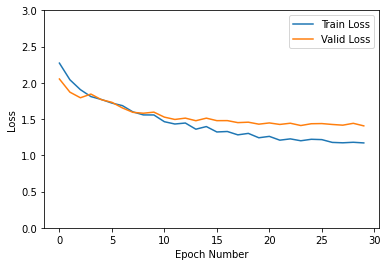

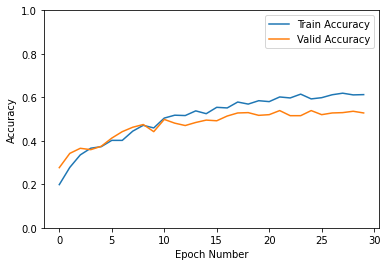

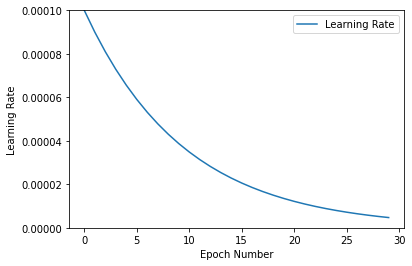

In [ ]:
torch.save(model,"./food-11.model_semi_9")

record_9 = np.array(record_9)
plt.plot(record_9[:, 0:2])
plt.legend(['Train Loss', 'Valid Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0, 3)
#plt.savefig('loss.png')
plt.show()

plt.plot(record_9[:, 2:4])
plt.legend(['Train Accuracy', 'Valid Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
#plt.savefig('accuracy.png')
plt.show()

plt.plot(record_9[:, 4])
plt.legend(['Learning Rate'])
plt.xlabel('Epoch Number')
plt.ylabel('Learning Rate')
plt.ylim(0, lr)
plt.show()

In [ ]:
model_9.eval()
predictions = []
for batch in test_loader:
    imgs, labels = batch
    with torch.no_grad():
        logits = model_9(imgs.to(device))
    predictions.extend(logits.argmax(dim=-1).cpu().numpy().tolist())

with open("predict9.csv", "w") as f:

    # The first row must be "Id, Category"
    f.write("Id,Category\n")

    # For the rest of the rows, each image id corresponds to a predicted class.
    for i, pred in  enumerate(predictions):
         f.write(f"{i},{pred} \n")

# Pretrained Model 

## The model use Pretrained Model + No_Semi + Augmentation 

In [ ]:
record_pre = []
semi_supervised = False

resnet = torchvision.models.resnet18(pretrained=True)
resnet.fc = nn.Sequential(
                nn.BatchNorm1d(resnet.fc.in_features),#important layer
                nn.Linear(resnet.fc.in_features, resnet.fc.in_features),
                nn.BatchNorm1d(resnet.fc.in_features),#important layer                
                nn.ReLU(),
                nn.Dropout(0.5),
                nn.Linear(resnet.fc.in_features, 1024),
                nn.BatchNorm1d(1024),#important layer                
                nn.ReLU(),
                nn.Dropout(0.5),
                nn.Linear(1024, 11),
            )    

model_pre = resnet.to(device)
model_pre.device = device
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_pre.parameters(), lr=lr, weight_decay=1e-5)
scheduler = ExponentialLR(optimizer=optimizer, gamma=gamma)
torch.cuda.empty_cache()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
for epoch in range(n_epochs): 
    if semi_supervised:
        pseudo_set,filter_index = get_pseudo_labels(unlabeled_set, model_pre,filter_index, batch_size,threshold=pseudo_threshold)
        concat_dataset = ConcatDataset([train_set, pseudo_set])
        print("train_set size: "+ str(len(train_set)))
        print("pseudo_set size: "+ str(len(pseudo_set)))
        print("concat_set size: "+ str(len(concat_dataset)))
        train_loader = DataLoader(concat_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True,drop_last=True)        
        
    model_pre.train()
    train_loss = []
    train_accs = []
    i = 0 
    start = time.time()
    for batch in train_loader:
        imgs, labels = batch
        logits = model_pre(imgs.to(device))
        loss = criterion(logits, labels.to(device))
        optimizer.zero_grad()
        loss.backward()
        grad_norm = nn.utils.clip_grad_norm_(model_pre.parameters(), max_norm=10)
        optimizer.step()
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()
        train_loss.append(loss.item())
        train_accs.append(acc)
        i = i + 1
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)

    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}, time = {time.time()-start:.2f}")

    model_pre.eval()
    valid_loss = []
    valid_accs = []
    start = time.time()
    for batch in valid_loader:
        imgs, labels = batch
        with torch.no_grad():
            logits = model_pre(imgs.to(device))

        loss = criterion(logits, labels.to(device))
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()
        valid_loss.append(loss.item())
        valid_accs.append(acc)
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)

    print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}, time = {time.time()-start:.2f}")
    
    record_pre.append([train_loss, valid_loss, train_acc.cpu(), valid_acc.cpu(),optimizer.param_groups[0]['lr']])    
    
    print("learning rate: "+ str(optimizer.param_groups[0]['lr']))
    scheduler.step()
    torch.cuda.empty_cache()
    
    if train_acc > (valid_acc+0.1):                    #allow +10% overfitting
        cnt_of_estop = cnt_of_estop + 1
    else:
        cnt_of_estop = 0

    if cnt_of_estop > early_stop_threshold:
        print("early stop break: " + str(cnt_of_estop))
        break
    else:
        print("early stop count: " + str(cnt_of_estop))      

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[ Train | 001/030 ] loss = 1.97478, acc = 0.34906, time = 28.91
[ Valid | 001/030 ] loss = 1.25539, acc = 0.70625, time = 6.51
learning rate: 0.0001
early stop count: 0
[ Train | 002/030 ] loss = 1.15731, acc = 0.70000, time = 29.18
[ Valid | 002/030 ] loss = 0.83637, acc = 0.75156, time = 6.47
learning rate: 9e-05
early stop count: 0
[ Train | 003/030 ] loss = 0.82459, acc = 0.78438, time = 30.06
[ Valid | 003/030 ] loss = 0.66653, acc = 0.81563, time = 6.60
learning rate: 8.1e-05
early stop count: 0
[ Train | 004/030 ] loss = 0.64804, acc = 0.83562, time = 29.08
[ Valid | 004/030 ] loss = 0.59189, acc = 0.82500, time = 6.53
learning rate: 7.290000000000001e-05
early stop count: 0
[ Train | 005/030 ] loss = 0.50664, acc = 0.86719, time = 29.42
[ Valid | 005/030 ] loss = 0.54057, acc = 0.83906, time = 6.53
learning rate: 6.561000000000002e-05
early stop count: 0
[ Train | 006/030 ] loss = 0.44018, acc = 0.88219, time = 29.08
[ Valid | 006/030 ] loss = 0.55084, acc = 0.83750, time = 6.6

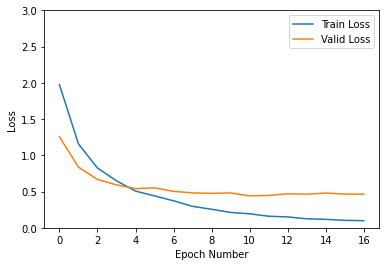

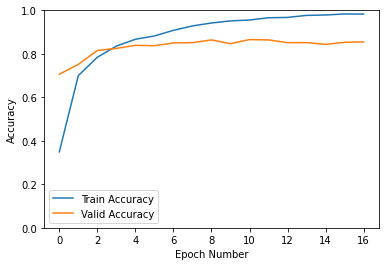

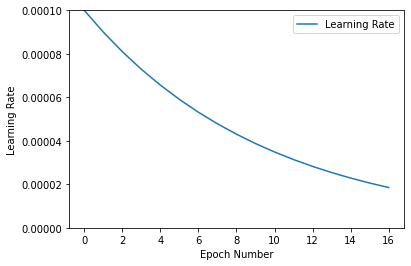

In [ ]:
torch.save(model,"./food-11.model_pre")

record_pre = np.array(record_pre)
plt.plot(record_pre[:, 0:2])
plt.legend(['Train Loss', 'Valid Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0, 3)
#plt.savefig('loss.png')
plt.show()

plt.plot(record_pre[:, 2:4])
plt.legend(['Train Accuracy', 'Valid Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
#plt.savefig('accuracy.png')
plt.show()

plt.plot(record_pre[:, 4])
plt.legend(['Learning Rate'])
plt.xlabel('Epoch Number')
plt.ylabel('Learning Rate')
plt.ylim(0, lr)
plt.show()

In [ ]:
model_pre.eval()
predictions = []
for batch in test_loader:
    imgs, labels = batch
    with torch.no_grad():
        logits = model_pre(imgs.to(device))
    predictions.extend(logits.argmax(dim=-1).cpu().numpy().tolist())
with open("predictpre.csv", "w") as f:

    # The first row must be "Id, Category"
    f.write("Id,Category\n")

    # For the rest of the rows, each image id corresponds to a predicted class.
    for i, pred in  enumerate(predictions):
         f.write(f"{i},{pred} \n")

## The model use Pretrained Model + Threshold 0.6 + Augmentation 


In [ ]:
record_pre_6 = []
pseudo_threshold = 0.6
semi_supervised = True

resnet = torchvision.models.resnet18(pretrained=True)
resnet.fc = nn.Sequential(
                nn.BatchNorm1d(resnet.fc.in_features),#important layer
                nn.Linear(resnet.fc.in_features, resnet.fc.in_features),
                nn.BatchNorm1d(resnet.fc.in_features),#important layer                
                nn.ReLU(),
                nn.Dropout(0.5),
                nn.Linear(resnet.fc.in_features, 1024),
                nn.BatchNorm1d(1024),#important layer                
                nn.ReLU(),
                nn.Dropout(0.5),
                nn.Linear(1024, 11),
            )    

model_pre_6 = resnet.to(device)
model_pre_6.device = device
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_pre_6.parameters(), lr=lr, weight_decay=1e-5)
scheduler = ExponentialLR(optimizer=optimizer, gamma=gamma)
torch.cuda.empty_cache()

In [ ]:
for epoch in range(n_epochs): 
    if semi_supervised:
        pseudo_set,filter_index = get_pseudo_labels(unlabeled_set, model_pre_6,filter_index, batch_size,threshold=pseudo_threshold)
        concat_dataset = ConcatDataset([train_set, pseudo_set])
        print("train_set size: "+ str(len(train_set)))
        print("pseudo_set size: "+ str(len(pseudo_set)))
        print("concat_set size: "+ str(len(concat_dataset)))
        train_loader = DataLoader(concat_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True,drop_last=True)        
        
    model_pre_6.train()
    train_loss = []
    train_accs = []
    i = 0 
    start = time.time()
    for batch in train_loader:
        imgs, labels = batch
        logits = model_pre_6(imgs.to(device))
        loss = criterion(logits, labels.to(device))
        optimizer.zero_grad()
        loss.backward()
        grad_norm = nn.utils.clip_grad_norm_(model_pre_6.parameters(), max_norm=10)
        optimizer.step()
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()
        train_loss.append(loss.item())
        train_accs.append(acc)
        i = i + 1
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)

    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}, time = {time.time()-start:.2f}")

    model_pre_6.eval()
    valid_loss = []
    valid_accs = []
    start = time.time()
    for batch in valid_loader:
        imgs, labels = batch
        with torch.no_grad():
            logits = model_pre_6(imgs.to(device))

        loss = criterion(logits, labels.to(device))
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()
        valid_loss.append(loss.item())
        valid_accs.append(acc)
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)

    print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}, time = {time.time()-start:.2f}")
    
    record_pre_6.append([train_loss, valid_loss, train_acc.cpu(), valid_acc.cpu(),optimizer.param_groups[0]['lr']])    
    
    print("learning rate: "+ str(optimizer.param_groups[0]['lr']))
    scheduler.step()
    torch.cuda.empty_cache()
    
    if train_acc > (valid_acc+0.1):                    #allow +10% overfitting
        cnt_of_estop = cnt_of_estop + 1
    else:
        cnt_of_estop = 0

    if cnt_of_estop > early_stop_threshold:
        print("early stop break: " + str(cnt_of_estop))
        break
    else:
        print("early stop count: " + str(cnt_of_estop))      

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_set size: 3080
pseudo_set size: 0
concat_set size: 3080
[ Train | 001/030 ] loss = 1.93872, acc = 0.37337, time = 27.69
[ Valid | 001/030 ] loss = 1.24642, acc = 0.67500, time = 6.59
learning rate: 0.0001
early stop count: 0
train_set size: 3080
pseudo_set size: 1229
concat_set size: 4309
[ Train | 002/030 ] loss = 1.36768, acc = 0.55737, time = 42.59
[ Valid | 002/030 ] loss = 0.99456, acc = 0.67813, time = 6.63
learning rate: 9e-05
early stop count: 0
train_set size: 3080
pseudo_set size: 1660
concat_set size: 4740
[ Train | 003/030 ] loss = 1.08728, acc = 0.54540, time = 42.05
[ Valid | 003/030 ] loss = 0.84495, acc = 0.75469, time = 6.72
learning rate: 8.1e-05
early stop count: 0
train_set size: 3080
pseudo_set size: 1971
concat_set size: 5051
[ Train | 004/030 ] loss = 0.94216, acc = 0.57712, time = 48.11
[ Valid | 004/030 ] loss = 0.76641, acc = 0.79844, time = 6.57
learning rate: 7.290000000000001e-05
early stop count: 0
train_set size: 3080
pseudo_set size: 2763
concat_se

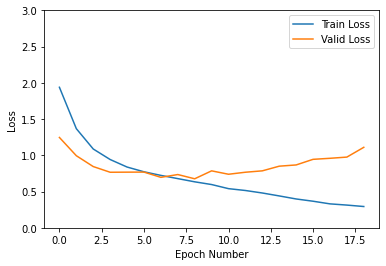

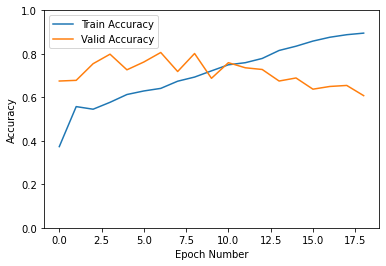

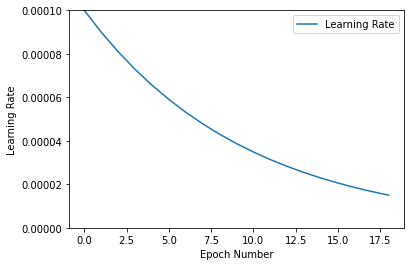

In [ ]:
torch.save(model,"./food-11.model_pre_6")

record_pre_6 = np.array(record_pre_6)
plt.plot(record_pre_6[:, 0:2])
plt.legend(['Train Loss', 'Valid Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0, 3)
#plt.savefig('loss.png')
plt.show()

plt.plot(record_pre_6[:, 2:4])
plt.legend(['Train Accuracy', 'Valid Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
#plt.savefig('accuracy.png')
plt.show()

plt.plot(record_pre_6[:, 4])
plt.legend(['Learning Rate'])
plt.xlabel('Epoch Number')
plt.ylabel('Learning Rate')
plt.ylim(0, lr)
plt.show()

In [ ]:
model_pre_6.eval()
predictions = []
for batch in test_loader:
    imgs, labels = batch
    with torch.no_grad():
        logits = model_pre_6(imgs.to(device))
    predictions.extend(logits.argmax(dim=-1).cpu().numpy().tolist())

with open("predictpre_6.csv", "w") as f:

    # The first row must be "Id, Category"
    f.write("Id,Category\n")

    # For the rest of the rows, each image id corresponds to a predicted class.
    for i, pred in  enumerate(predictions):
         f.write(f"{i},{pred} \n")

## The model use Pretrained Model + Threshold 0.9 + Augmentation 



In [ ]:
record_pre_9 = []
pseudo_threshold = 0.9
semi_supervised = True

resnet = torchvision.models.resnet18(pretrained=True)
resnet.fc = nn.Sequential(
                nn.BatchNorm1d(resnet.fc.in_features),#important layer
                nn.Linear(resnet.fc.in_features, resnet.fc.in_features),
                nn.BatchNorm1d(resnet.fc.in_features),#important layer                
                nn.ReLU(),
                nn.Dropout(0.5),
                nn.Linear(resnet.fc.in_features, 1024),
                nn.BatchNorm1d(1024),#important layer                
                nn.ReLU(),
                nn.Dropout(0.5),
                nn.Linear(1024, 11),
            )    

model_pre_9 = resnet.to(device)
model_pre_9.device = device
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_pre_9.parameters(), lr=lr, weight_decay=1e-5)
scheduler = ExponentialLR(optimizer=optimizer, gamma=gamma)
torch.cuda.empty_cache()

In [ ]:
for epoch in range(n_epochs): 
    if semi_supervised:
        pseudo_set,filter_index = get_pseudo_labels(unlabeled_set, model_pre_9,filter_index, batch_size,threshold=pseudo_threshold)
        concat_dataset = ConcatDataset([train_set, pseudo_set])
        print("train_set size: "+ str(len(train_set)))
        print("pseudo_set size: "+ str(len(pseudo_set)))
        print("concat_set size: "+ str(len(concat_dataset)))
        train_loader = DataLoader(concat_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True,drop_last=True)        
        
    model_pre_9.train()
    train_loss = []
    train_accs = []
    i = 0 
    start = time.time()
    for batch in train_loader:
        imgs, labels = batch
        logits = model_pre_9(imgs.to(device))
        loss = criterion(logits, labels.to(device))
        optimizer.zero_grad()
        loss.backward()
        grad_norm = nn.utils.clip_grad_norm_(model_pre_9.parameters(), max_norm=10)
        optimizer.step()
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()
        train_loss.append(loss.item())
        train_accs.append(acc)
        i = i + 1
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)

    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}, time = {time.time()-start:.2f}")

    model_pre_9.eval()
    valid_loss = []
    valid_accs = []
    start = time.time()
    for batch in valid_loader:
        imgs, labels = batch
        with torch.no_grad():
            logits = model_pre_9(imgs.to(device))

        loss = criterion(logits, labels.to(device))
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()
        valid_loss.append(loss.item())
        valid_accs.append(acc)
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)

    print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}, time = {time.time()-start:.2f}")
    
    record_pre_9.append([train_loss, valid_loss, train_acc.cpu(), valid_acc.cpu(),optimizer.param_groups[0]['lr']])    
    
    print("learning rate: "+ str(optimizer.param_groups[0]['lr']))
    scheduler.step()
    torch.cuda.empty_cache()
    
    if train_acc > (valid_acc+0.1):                    #allow +10% overfitting
        cnt_of_estop = cnt_of_estop + 1
    else:
        cnt_of_estop = 0

    if cnt_of_estop > early_stop_threshold:
        print("early stop break: " + str(cnt_of_estop))
        break
    else:
        print("early stop count: " + str(cnt_of_estop))      

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train_set size: 3080
pseudo_set size: 0
concat_set size: 3080
[ Train | 001/030 ] loss = 1.92844, acc = 0.38053, time = 22.93
[ Valid | 001/030 ] loss = 1.21184, acc = 0.68437, time = 5.64
learning rate: 0.0001
early stop count: 0
train_set size: 3080
pseudo_set size: 409
concat_set size: 3489
[ Train | 002/030 ] loss = 1.28553, acc = 0.63050, time = 28.28
[ Valid | 002/030 ] loss = 0.87921, acc = 0.76875, time = 5.57
learning rate: 9e-05
early stop count: 0
train_set size: 3080
pseudo_set size: 437
concat_set size: 3517
[ Train | 003/030 ] loss = 1.01233, acc = 0.68605, time = 25.33
[ Valid | 003/030 ] loss = 0.76121, acc = 0.78281, time = 5.71
learning rate: 8.1e-05
early stop count: 0
train_set size: 3080
pseudo_set size: 1096
concat_set size: 4176
[ Train | 004/030 ] loss = 0.89064, acc = 0.69952, time = 32.35
[ Valid | 004/030 ] loss = 0.73193, acc = 0.76250, time = 5.54
learning rate: 7.290000000000001e-05
early stop count: 0
train_set size: 3080
pseudo_set size: 956
concat_set s

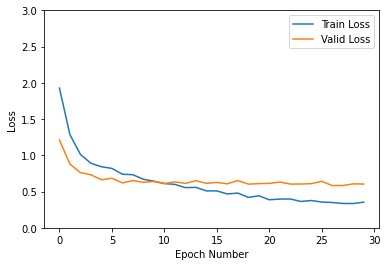

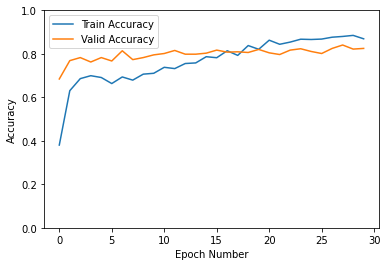

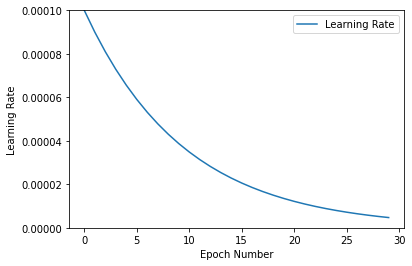

In [ ]:
torch.save(model,"./food-11.model_pre_9")

record_pre_9 = np.array(record_pre_9)
plt.plot(record_pre_9[:, 0:2])
plt.legend(['Train Loss', 'Valid Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0, 3)
plt.show()

plt.plot(record_pre_9[:, 2:4])
plt.legend(['Train Accuracy', 'Valid Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()

plt.plot(record_pre_9[:, 4])
plt.legend(['Learning Rate'])
plt.xlabel('Epoch Number')
plt.ylabel('Learning Rate')
plt.ylim(0, lr)
plt.show()

In [ ]:
model_pre_9.eval()
predictions = []
for batch in test_loader:
    imgs, labels = batch
    with torch.no_grad():
        logits = model_pre_9(imgs.to(device))
    predictions.extend(logits.argmax(dim=-1).cpu().numpy().tolist())

with open("predictpre_9.csv", "w") as f:
    # The first row must be "Id, Category"
    f.write("Id,Category\n")

    # For the rest of the rows, each image id corresponds to a predicted class.
    for i, pred in  enumerate(predictions):
         f.write(f"{i},{pred} \n")